In [1]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlGDConfig,
    ControlEMVPConfig,
    ProposedMethodConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
from simple_ls_optimizer import SimpleLSOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator
from cv_embedding_estimation import CrossValidationEmbeddingEstimator, estimate_embedding_cv
from itertools import product
import seaborn as sns
from matplotlib.colors import LogNorm
import rdatasets


## Loading the dataset

In [2]:
DATASETS = set(["lynx", "ozone"])

In [3]:
DATASET = "lynx"

assert DATASET in DATASETS, f"Dataset {DATASET} not recognized. Available datasets: {DATASETS}"

In [4]:
# dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
match DATASET:
    case "lynx":
        dataset = rdatasets.data("lynx").drop(columns=["rownames"])
        dataset.set_index('time', inplace=True)
    case "ozone":
        dataset = pd.read_csv("./data/Arosa_Ozone_Thickness_Dataset.csv")
        dataset["year"] = 1925 + dataset["year"]
        dataset["time"] = pd.to_datetime(dataset[["year", "month"]].assign(day=1))
        dataset.set_index("time", inplace=True)
        dataset = dataset.rename(columns={
            "thick": "value"
        }).drop(columns=["year", "month"])
dataset.head()

,value
time,
1821,269
1822,321
1823,585
1824,871
1825,1475


In [5]:
dataset.describe()

,value
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


In [6]:
# time_series = dataset['Value'].values
time_series = dataset['value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [7]:
# time_series_mu = np.mean(time_series)
# time_series_std = np.std(time_series)

# time_series = np.diff(time_series, prepend=time_series[0])
# time_series = (time_series - time_series_mu) / time_series_std
match DATASET:
    case "lynx":
        time_series = np.log10(time_series)
    case "ozone":
        time_series = np.log10(time_series - 260)

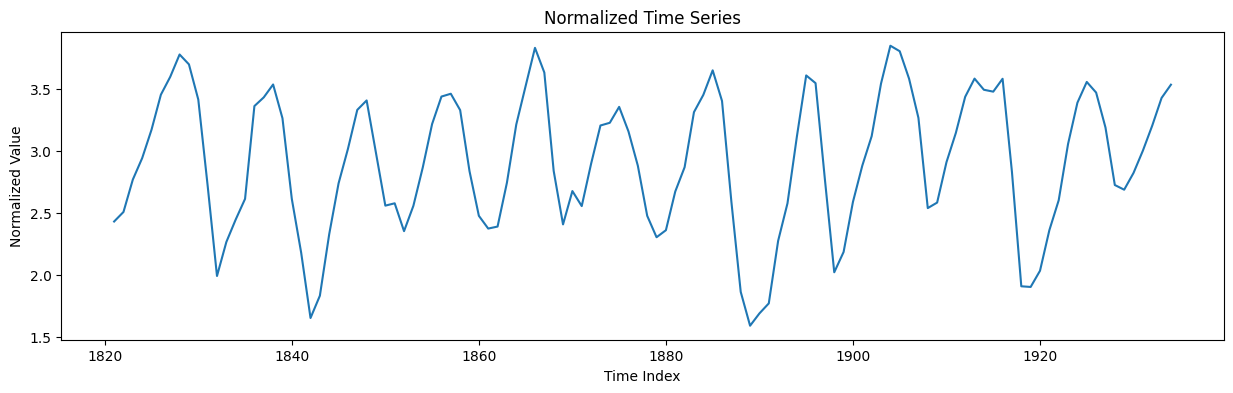

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(dataset.index, time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [9]:
ami_tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {ami_tau}")

Estimated tau: 2


In [10]:
cao_dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=ami_tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=False,
    ),
)
print(f"Estimated dimension: {cao_dim}")

Estimated dimension: 7


## Testing Cross-Validation Embedding Estimation

Let's compare the traditional AMI + Cao's method with the new modified multifold cross-validation criterion for embedding parameter estimation.

In [11]:
# Compare traditional AMI + Cao estimation with CV-based estimation
print("=== Traditional Methods (AMI + Cao) ===")
print(f"AMI estimated tau: {ami_tau}")
print(f"Cao estimated dimension: {cao_dim}")

# Use CV-based estimation with a smaller parameter space for faster computation
print("\n=== Cross-Validation Based Estimation ===")
cv_estimator = CrossValidationEmbeddingEstimator(
    tau_range=(1, 5),      # Smaller range for demonstration
    dim_range=(2, 6),      # Smaller range for demonstration  
    n_splits=3,            # Fewer splits for faster computation
    scoring_metric="mse",  # Mean squared error
    verbose=False
)

tau_cv, dim_cv = cv_estimator.estimate(time_series)
print(f"CV estimated tau: {tau_cv}")
print(f"CV estimated dimension: {dim_cv}")

=== Traditional Methods (AMI + Cao) ===
AMI estimated tau: 2
Cao estimated dimension: 7

=== Cross-Validation Based Estimation ===
CV estimated tau: 1
CV estimated dimension: 2


In [12]:
# You can also try different scoring metrics
print("\n=== CV with different scoring metrics ===")

metrics = ["mse", "mae", "r2"]
cv_results = {}

for metric in metrics:
    estimator = CrossValidationEmbeddingEstimator(
        tau_range=(1, 4),
        dim_range=(2, 5),
        n_splits=3,
        scoring_metric=metric,
        verbose=False  # Set to True to see progress
    )
    tau_est, dim_est = estimator.estimate(time_series)
    cv_results[metric] = (tau_est, dim_est)
    print(f"{metric.upper()} metric: tau={tau_est}, dim={dim_est}")

print(f"\nComparison:")
print(f"Traditional (AMI+Cao): tau={ami_tau}, dim={cao_dim}")
for metric, (tau_est, dim_est) in cv_results.items():
    print(f"CV ({metric}): tau={tau_est}, dim={dim_est}")


=== CV with different scoring metrics ===
MSE metric: tau=1, dim=2
MAE metric: tau=1, dim=2
R2 metric: tau=1, dim=2

Comparison:
Traditional (AMI+Cao): tau=2, dim=7
CV (mse): tau=1, dim=2
CV (mae): tau=1, dim=2
CV (r2): tau=1, dim=2


## Configuring the models

In [13]:
tau, dim = tau_cv, dim_cv

In [14]:
proposed_configs = [
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=SvdOptimizer(epsilon=eps, alpha=alpha, beta=beta),
            m=m,
            post_tune=post_tune,
            n=dim,
            embedding_tau=tau,
            tuning_val_split=tuning_val_split,
            ridge=ridge # for pre-training
        )
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 150, 300]
        # for m in [10, 15, 300]
        for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5]
        for beta in [None, 1, 10, 100]
        # for beta in [None]
        for eps in [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
        # for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        # for approach in ["pretraining", "no-pretraining"]
        for post_tune, tuning_val_split in filter(
            lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
            product([True, False], [0.0, 0.15])
        )
        for ridge, approach in filter(
            lambda ra: not (ra[0] > 0 and ra[1] == "no-pretraining"), 
            product(
                [0.0, 1e-3, 1e-2, 1e-1, 1, 5], 
                ["pretraining", "no-pretraining"]
            )
        )
    ],
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=SimpleLSOptimizer(alpha=alpha),
            m=m,
            post_tune=post_tune,
            n=dim,
            embedding_tau=tau,
            tuning_val_split=tuning_val_split,
            ridge=ridge # for pre-training
        )
        # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
        for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5]
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 225, 300]
        # for approach in ["pretraining", "no-pretraining"]
        for post_tune, tuning_val_split in filter(
            lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
            product([True, False], [0.0, 0.15])
        )
        for ridge, approach in filter(
            lambda ra: not (ra[0] > 0 and ra[1] == "no-pretraining"), 
            product(
                [0.0, 1e-3, 1e-2, 1e-1], 
                ["pretraining", "no-pretraining"]
            )
        )
    ],
    # *[
    #     ProposedMethodConfig(
    #         approach=approach,
    #         optimizer=OlsOptimizer(rho=rho, alpha=alpha),
    #         m=max_m,
    #         n=dim,
    #         embedding_tau=tau,
    #         post_tune=post_tune,
    #         ridge=ridge,
    #         tuning_val_split=tuning_val_split
    #     )
    #     for alpha in [0, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1, 2, 5, 10, 20, 50]
    #     for max_m in [50, 100, 300]
    #     for post_tune, tuning_val_split in filter(
    #         lambda pt_tv: not pt_tv[0] or pt_tv[1] > 0.0, 
    #         product([True, False], [0.0, 0.15, 0.3])
    #     )        for rho in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
    #     for ridge, approach in filter(
    #         lambda ra: not (ra[0] > 0 and ra[1] == "no-pretraining"), 
    #         product(
    #             [0.0, 1e-4, 1e-3, 1e-2, 1e-1], 
    #             ["pretraining", "no-pretraining"]
    #         )
    #     )
    # ],
]

control_configs = [
    *[
        ControlGDConfig(
            m=m,
            n=dim,
            embedding_tau=tau,
            lr=lr,
            sigma_global=sigma_global,
            ridge=ridge,
            val_split=0.15,
        )
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20]
        for lr in [1e-3, 1e-2, 5e-2, 1e-1]
        for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        for sigma_global in [False, True]
    ],
    *[
        ControlEMVPConfig(
            n=dim,
            embedding_tau=tau,
            num_components=m,
            ridge=ridge
        )
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 20, 100]
        for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        # for m in [10]
        # for ridge in [0]
    ]
]

In [15]:
TRAIN_RATIOS = {
    # "lynx": 0.88, # 0.88 for equivalence with article (no validation-test set separation though...) 
    "lynx": 0.7,
    # "ozone": 450/518
    "ozone": 0.7
}

train_ratio = TRAIN_RATIOS.get(DATASET, 0.7)

In [16]:
proposed_results, control_results = run_comparison_experiments(
        time_series,
        proposed_configs,
        control_configs,
        train_ratio=train_ratio, # 0.88 matches the article which introduces the EM-VP algorithm
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]
if not isinstance(control_results, list):
    control_results = [control_results]

Running Experiments: 100%|██████████| 80953/80953 [44:58<00:00, 30.00experiment/s]  


## Evaluating the results

In [17]:
VALID_RATIOS = {
    # "lynx": 0.06, 
    "lynx": 0.2, 
    # "ozone": 34/518
    "ozone": 0.2
}

valid_ratio = VALID_RATIOS.get(DATASET, 0.2)

test_ratio = 1.0 - train_ratio - valid_ratio
assert test_ratio > 0, "Test ratio must be positive."

In [18]:
results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test MSE": [],
        "Test RMSE": [],
        "Test NRMSE": [],
        "Test MAPE": [],
        "Test SMAPE": [],
        "Test MAAPE": [],
        "Valid R": [],
        "Valid R^2": [],
        "Valid MSE": [],
        "Valid RMSE": [],
        "Valid NRMSE": [],
        "Valid MAPE": [],
        "Valid SMAPE": [],
        "Valid MAAPE": [],
    }
)


use_validation_set = valid_ratio > 0

for i, res in enumerate(proposed_results):
    
    cfg = proposed_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * valid_ratio)
    
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets,
    )
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.metadata['optimizer_type']}-w.{cfg.approach}"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test RMSE": [test_metrics.root_mean_squared_error()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

for i, res in enumerate(control_results):
    
    cfg = control_configs[i]
    
    validation_cutoff = int((len(res.test_targets) + len(res.train_targets)) * valid_ratio)
    
    if use_validation_set:
        valid_metrics = RegressionMetric(
            y_pred=res.test_predictions[:validation_cutoff],
            y_true=res.test_targets[:validation_cutoff],
        )
    
    control_test_metrics = RegressionMetric(
        y_pred=res.test_predictions[validation_cutoff:] if use_validation_set else res.test_predictions,
        y_true=res.test_targets[validation_cutoff:] if use_validation_set else res.test_targets
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Control"],
            "Name": [f"{'GD-' if isinstance(cfg, ControlGDConfig) else 'EMVP'} "],
            "Test R": [control_test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [control_test_metrics.R2()],
            "Test RMSE": [control_test_metrics.root_mean_squared_error()],
            "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [control_test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [control_test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [control_test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [control_test_metrics.mean_squared_error()],
            "Valid R": [valid_metrics.pearson_correlation_coefficient()] if use_validation_set else [np.nan],
            "Valid R^2": [valid_metrics.R2()] if use_validation_set else [np.nan],
            "Valid MSE": [valid_metrics.mean_squared_error()] if use_validation_set else [np.nan],
            "Valid RMSE": [valid_metrics.root_mean_squared_error()] if use_validation_set else [np.nan],
            "Valid NRMSE": [valid_metrics.normalized_root_mean_square_error()] if use_validation_set else [np.nan],
            "Valid MAPE": [valid_metrics.mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid SMAPE": [valid_metrics.symmetric_mean_absolute_percentage_error()] if use_validation_set else [np.nan],
            "Valid MAAPE": [valid_metrics.mean_arctangent_absolute_percentage_error()] if use_validation_set else [np.nan],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

In [85]:
MODEL_SELECTION_CRITERION = "Valid MSE"
MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = False

MODEL_EVALUATION_CRITERION = "Test MSE"
MODEL_EVALUATION_CRITERION_SHOULD_MAXIMIZE = False

In [86]:
results_df.assign(
    Optimizer=results_df['Name'].str.split('-').str[0],
    Approach=results_df['Name'].str.extract(r'-w\.(.+)')[0].fillna('N/A')
).groupby(["Type", "Optimizer", "Approach"])[results_df.columns].apply(
    lambda x: x.sort_values(
        by=MODEL_SELECTION_CRITERION,
        ascending=not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE,
    )
    .drop(
        columns=[
            "Type",
            *[col for col in results_df.columns if col.startswith("Valid") and col != MODEL_SELECTION_CRITERION and col != "Approach"],
        ]
    )
    .head(1)
)

Name  \
Type     Optimizer         Approach                                                   
Control  EMVP              N/A            80893                               EMVP    
         GD                N/A            80451                                GD-    
Proposed SimpleLSOptimizer no-pretraining 78565  SimpleLSOptimizer-w.no-pretraining   
                           pretraining    78393     SimpleLSOptimizer-w.pretraining   
         SvdOptimizer      no-pretraining 31165       SvdOptimizer-w.no-pretraining   
                           pretraining    28826          SvdOptimizer-w.pretraining   

                                                   Test R  Test R^2  Test MSE  \
Type     Optimizer         Approach                                             
Control  EMVP              N/A            80893  0.868471  0.696697  0.027209   
         GD                N/A            80451  0.961353  0.877768  0.010965   
Proposed SimpleLSOptimizer no-pretraining 78565  0.961804  0.880649  0.010707   
                           pretraining    78393  0.961044  0.867651  0.011873   
         SvdOptimizer      no-pretraining 31165  0.941543  0.863224  0.012270   
                           pretraining    28826  0.972989  0.902742  0.008725   

                                                 Test RMSE  Test NRMSE  \
Type     Optimizer         Approach                                      
Control  EMVP              N/A            80893   0.164950    0.523609   
         GD                N/A            80451   0.104715    0.320849   
Proposed SimpleLSOptimizer no-pretraining 78565   0.103473    0.310069   
                           pretraining    78393   0.108962    0.320709   
         SvdOptimizer      no-pretraining 31165   0.110769    0.341199   
                           pretraining    28826   0.093406    0.288698   

                                                 Test MAPE  Test SMAPE  \
Type     Optimizer         Approach                                      
Control  EMVP              N/A            80893   0.043007    0.021947   
         GD                N/A            80451   0.024544    0.012581   
Proposed SimpleLSOptimizer no-pretraining 78565   0.028492    0.014484   
                           pretraining    78393   0.029670    0.015105   
         SvdOptimizer      no-pretraining 31165   0.028013    0.013927   
                           pretraining    28826   0.023837    0.012155   

                                                 Test MAAPE  Valid MSE  
Type     Optimizer         Approach                                     
Control  EMVP              N/A            80893    0.042920   0.064655  
         GD                N/A            80451    0.024509   0.071087  
Proposed SimpleLSOptimizer no-pretraining 78565    0.028465   0.042667  
                           pretraining    78393    0.029643   0.048004  
         SvdOptimizer      no-pretraining 31165    0.027986   0.041328  
                           pretraining    28826    0.023819   0.050780

In [76]:
print(f"Best proposed model is: {results_df.sort_values(by=["Type", MODEL_SELECTION_CRITERION], ascending=[False, not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(1)["Name"].values[0]}")

Best proposed model is: SvdOptimizer-w.no-pretraining


In [22]:
AXIS_LIM = (0, 1)

Correlations between Valid and Test metrics:
Control 0.9162025218564935
Proposed 0.9993524100191908


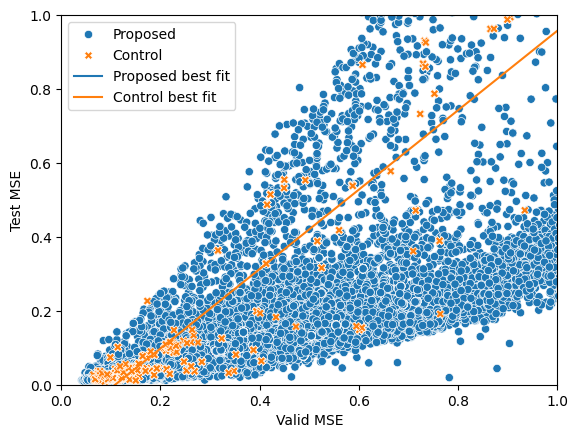

In [87]:
valid_metric = (
    MODEL_SELECTION_CRITERION
    if MODEL_SELECTION_CRITERION.startswith("Valid")
    else "Valid " + MODEL_SELECTION_CRITERION.split(" ")[1]
)
test_metric = (
    "Test " + MODEL_EVALUATION_CRITERION.split(" ")[1]
    if MODEL_EVALUATION_CRITERION.startswith("Valid")
    else MODEL_EVALUATION_CRITERION
)
sns.scatterplot(
    data=results_df, x=valid_metric, y=test_metric, hue="Type", style="Type"
)
plt.xlim(*AXIS_LIM)
plt.ylim(*AXIS_LIM)
# Calculate correlations for each category
correlations = results_df.groupby("Type")[results_df.columns].apply(
    lambda df: df[valid_metric].corr(df[test_metric])
)
print("Correlations between Valid and Test metrics:")
print("Control", correlations.get("Control", np.nan))
print("Proposed", correlations.get("Proposed", np.nan))

# Add best fit lines for each category
for typ in results_df["Type"].unique():
    subset = results_df[results_df["Type"] == typ]
    x = subset[valid_metric]
    y = subset[test_metric]
    m, b = np.polyfit(x, y, 1)
    x_line = np.linspace(*AXIS_LIM, 100)
    plt.plot(x_line, m * x_line + b, label=f"{typ} best fit")
plt.legend()
plt.show()

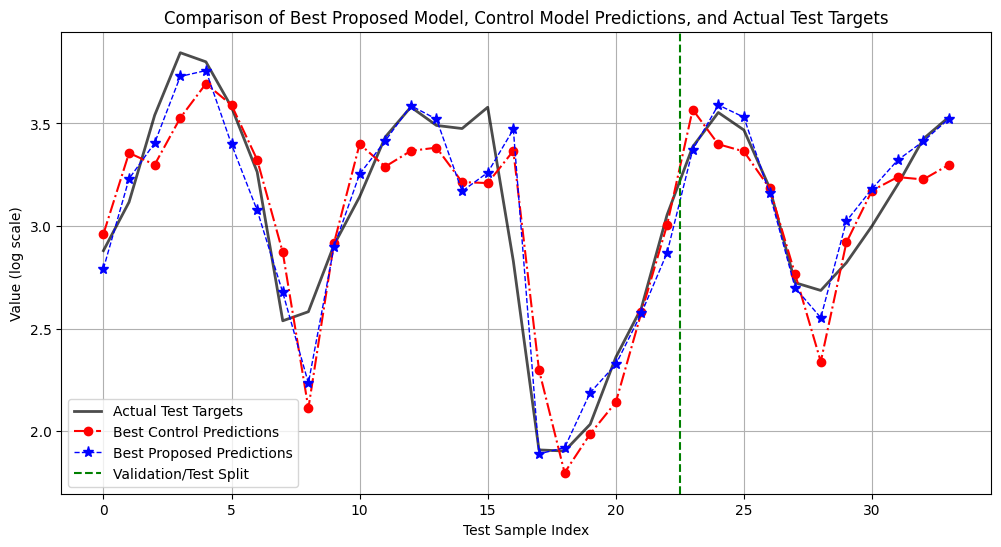

In [24]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_proposed_res = proposed_results[best_proposed_idx]

best_control_idx = results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmax() if MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Control"][
    MODEL_SELECTION_CRITERION
].idxmin()
best_control_res = control_results[best_control_idx - len(proposed_results)]

# Get test targets (actual values for test set)
test_targets = best_proposed_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label="Actual Test Targets", color="black", linewidth=2,  alpha=.7)
plt.plot(
    best_control_res.test_predictions,
    label=f"Best Control Predictions",
    color="red",
    linestyle="-.",
    marker='o',
)
plt.plot(
    best_proposed_res.test_predictions,
    label=f'Best Proposed Predictions',
    color="blue",
    linestyle="--",
    linewidth=1,
    marker='*',
    markersize=8,
)
plt.axvline(x=validation_cutoff + 0.5, color='green', linestyle='--', label='Validation/Test Split')
plt.xlabel("Test Sample Index")
plt.ylabel("Value (log scale)")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()

### Effects of individual hyperparameters

In [54]:
HYPERPARAM = "optimizer._alpha"
# HYPERPARAM = "optimizer._delta"
# HYPERPARAM = "ridge"
# HYPERPARAM = "num_components"
# HYPERPARAM = "post_tune"
# HYPERPARAM = "m"
# HYPERPARAM = "approach"
# HYPERPARAM = "optimizer._beta"
METRIC_LOG_SCALE = True
PARAM_LOG_SCALE = True

PROPOSED_HYPERPARAM = True

# NAME_SET = set(["EMVP"])
NAME_SET = None

In [55]:
DIST_PLOT_X_LIM = (0, 0.012)

In [56]:

hyperparam_values = (
    map(
        lambda cfg: cfg.__dict__.get(HYPERPARAM, None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
    if not HYPERPARAM.startswith("optimizer.")
    else
    map(
        lambda cfg: cfg.optimizer.__dict__.get(HYPERPARAM.split(".")[1], None),
        proposed_configs if PROPOSED_HYPERPARAM else control_configs,
    )
)


hyperparam_results_df = results_df[results_df["Type"] == ("Proposed" if PROPOSED_HYPERPARAM else "Control")].copy()
hyperparam_results_df[HYPERPARAM] = list(hyperparam_values)

In [57]:
hyperparam_results_df = hyperparam_results_df[
            (hyperparam_results_df[test_metric] <= DIST_PLOT_X_LIM[1]) & (hyperparam_results_df[test_metric] >= DIST_PLOT_X_LIM[0] )    
        ]
assert not hyperparam_results_df.empty, "No results found within the specified DIST_PLOT_X_LIM."

if NAME_SET is not None:
    hyperparam_results_df = hyperparam_results_df[
        hyperparam_results_df["Name"].str.strip().isin(NAME_SET)
    ]
    assert not hyperparam_results_df.empty, "No results found with the specified names."
    
assert hyperparam_results_df[HYPERPARAM].nunique() >= 1, "Hyperparameter has only one unique value; cannot plot."

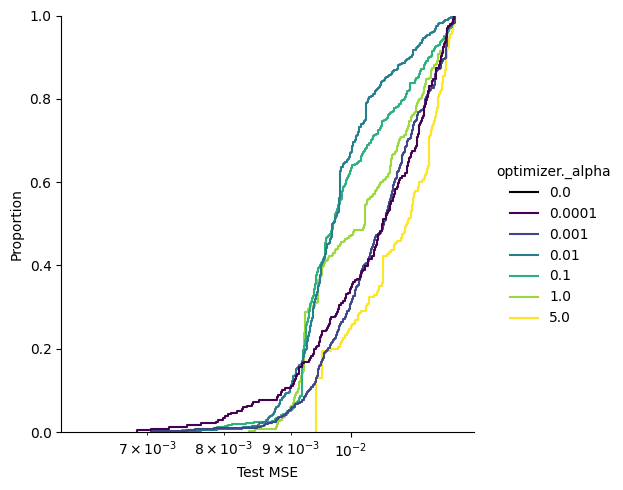

In [58]:
from pandas.api.types import is_numeric_dtype, is_bool_dtype

try:
    sns.displot(
        data=hyperparam_results_df,
        x=test_metric,
        hue=HYPERPARAM,
        hue_norm=(
            LogNorm()
            if PARAM_LOG_SCALE
            and is_numeric_dtype(hyperparam_results_df[HYPERPARAM])
            and not is_bool_dtype(hyperparam_results_df[HYPERPARAM])
            else None
        ),
        kind="ecdf",
        palette="viridis",
        log_scale=(METRIC_LOG_SCALE, False),
    )
except TypeError:
    sns.displot(
        data=hyperparam_results_df,
        x=test_metric,
        hue=HYPERPARAM,
        kind="ecdf",
        palette="viridis",
        log_scale=(METRIC_LOG_SCALE, False),
    )
# plt.xlim(right= np.log10(hyperparam_results_df[test_metric].max() / 10))
plt.show()

### Control models

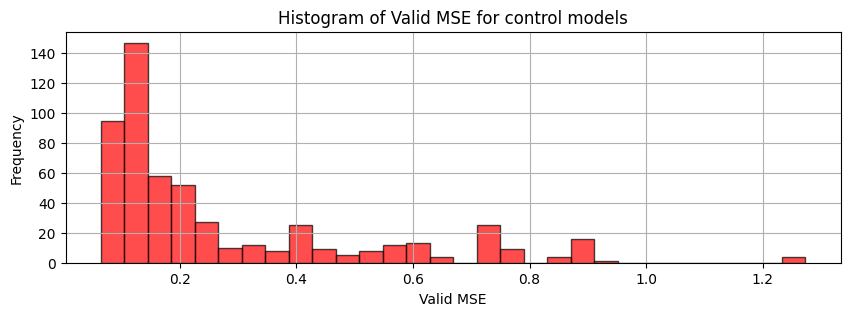

In [30]:
control_models = results_df[results_df["Type"] == "Control"]
plt.figure(figsize=(10, 3))
plt.hist(control_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for control models')
plt.xlabel(MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Breakdown of methods

#### Best OLS model without tuning

In [31]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
not_tuned_ols_models = results_df[
    results_df["Name"].str.contains("OLS", case=False, na=False)
    & results_df["Name"].str.contains("tuned=False", case=False, na=False)
]

if not_tuned_ols_models.empty:
    best_not_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_ols_model = not_tuned_ols_models.loc[
        (
            not_tuned_ols_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_ols_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

if best_not_tuned_ols_model is None:
    print("No untuned OLS models found.")
else:
    print(best_not_tuned_ols_model["Name"])
    print("=" * 20)
    print(best_not_tuned_ols_model.drop(labels=["Type", "Name"]))

No untuned OLS models found.


In [32]:
if not not_tuned_ols_models.empty:
    plt.figure(figsize=(10, 3))
    plt.hist(not_tuned_ols_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for not tuned OLS Models')
    plt.xlabel(MODEL_SELECTION_CRITERION)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print("No untuned OLS models found, skipping histogram.")

No untuned OLS models found, skipping histogram.


#### Best OLS-based model with tuning

In [33]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
tuned_ols_models = results_df[results_df["Name"].str.contains("OLS", case=False, na=False) & 
                        results_df["Name"].str.contains("tuned=True", case=False, na=False)]

if tuned_ols_models.empty:
    best_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_ols_model = tuned_ols_models.loc[
        (
            tuned_ols_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_ols_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

if best_tuned_ols_model is None:
    print("No tuned OLS models found.")
else:
    print(best_tuned_ols_model["Name"])
    print("="*20)
    print(best_tuned_ols_model.drop(labels=["Type", "Name"]))

No tuned OLS models found.


In [34]:
if tuned_ols_models.empty:
    print("No tuned OLS models found, skipping histogram.")
else:
    plt.figure(figsize=(10, 3))
    plt.hist(tuned_ols_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for tuned OLS models')
    plt.xlabel(MODEL_SELECTION_CRITERION)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

No tuned OLS models found, skipping histogram.


#### Best SVD-based model without tuning

In [35]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
not_tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
not_tuned_svd_models = not_tuned_svd_models[not_tuned_svd_models["Name"].str.contains("tuned=False", case=False, na=False)]

if not_tuned_svd_models.empty:
    best_not_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_svd_model = not_tuned_svd_models.loc[
        (
            not_tuned_svd_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_svd_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_not_tuned_svd_model["Name"])
print("="*20)
print(best_not_tuned_svd_model.drop(labels=["Type", "Name"]))

TypeError: 'NoneType' object is not subscriptable

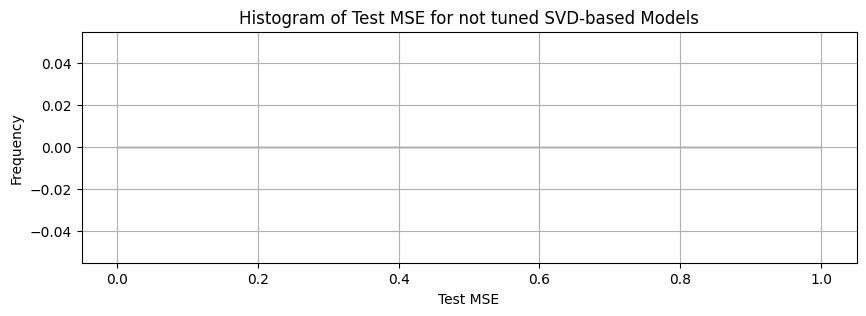

In [ ]:
plt.figure(figsize=(10, 3))
plt.hist(not_tuned_svd_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for not tuned SVD-based Models')
plt.xlabel(MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Best SVD-based model with tuning

In [ ]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
tuned_svd_models = tuned_svd_models[
    tuned_svd_models["Name"].str.contains("tuned=True", case=False, na=False)
]

if tuned_svd_models.empty:
    best_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_svd_model = tuned_svd_models.loc[
        (
            tuned_svd_models[MODEL_SELECTION_CRITERION].idxmin()
            if not MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_svd_models[MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_tuned_svd_model["Name"])
print("=" * 20)
print(best_tuned_svd_model.drop(labels=["Type", "Name"]))

TypeError: 'NoneType' object is not subscriptable

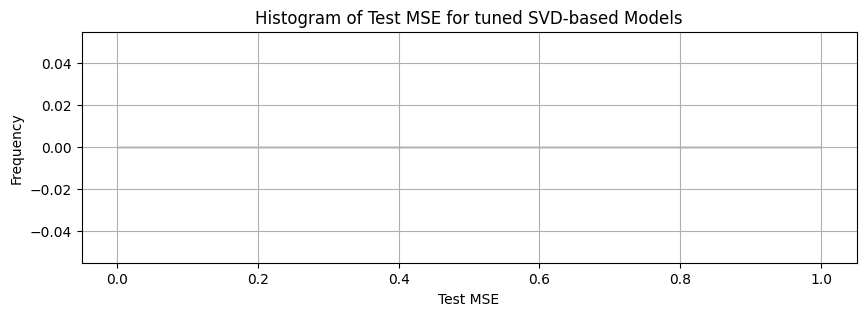

In [ ]:
plt.figure(figsize=(10, 3))
plt.hist(tuned_svd_models[MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {MODEL_SELECTION_CRITERION} for tuned SVD-based Models')
plt.xlabel(MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()